В задачах 1 и 2 есть замечания по их расширению/уличшению решения. Эти требования дополнительные. Решение будет полностью защитано и если если задача без учета замечания полностью решена.  

# Задача 1

Напишите код, который используя метод Монте-Карло расчитывал бы цену опциона EKI/KO.

EKI/KO опцион это Европейский опцион, для которого добавлено два барьера. Непрерывный барьер - действует точно так же как в KO опционе. EKI барьер действует только в момент экспирации опциона : для call опциона выплота происходит только если курс актива на момент экспирации больше уровня EKI, для опциона put выплата происходит только если курс ниже уровня EKI на момент экприрации.

Сделайте расчет для опциона call с параметрами указанными ниже

In [8]:
import numpy as np
from scipy import stats
import math as m
import scipy.linalg as linalg

def standard_normal(I):
    z = np.random.standard_normal(I)
    mean = np.mean(z)
    std = np.std(z)
    return (z - mean)/std 

S0 = 80.; K = 85.; T = 1.0; r = 0.05; q = 0.0; sigma = 0.2
B = 110 # continues barrier level
EKI = 90 # EKI level
M = 360 # number of steps in time
I = 50000 # number of paths to generate
def mc_pv_EKI_KO_withpaths(S0, K, T, r, sigma, M, I, B, EKI,call_put):
    # Simulating I paths with M time steps
    S = [S0]
    if(S0>B):
        return 0
    dt = float(T) / M
    V=I
    for t in range(1, M + 1):
        #на каждом шаге оставляем лишь те траектории, которые не вышли за пределы B
        z = standard_normal(V)
        S_b = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * m.sqrt(dt) * z)
        if call_put == "put":
            V = len(S_b[S_b > B])
            S.append(S_b[S_b > B])
        else:
            S.append(S_b[S_b < B])
            V = len(S_b[S_b < B])

    # ограничение EKI
    if call_put == "put":
        S[-1]=S[-1][S[-1]<EKI]
    else:
        S[-1]=S[-1][S[-1]>EKI]

    C = np.sum(m.exp(-r * T) * np.maximum(S[-1] - K, 0)) / I
    return C

In [9]:
print("цена call опциона EKI/KO: ",mc_pv_EKI_KO_withpaths(S0, K, T, r, sigma, M, I, B, EKI, "call"))

цена call опциона EKI/KO:  2.268125574050947


**замечание**

Код в задачах из лекции использует $O( M \cdot I )$ памяти. Попробуйте сделать код, который использует $O( I )$ памяти.

# Задача 2

Модифицируйте функцию, разобранную на лекции, для расчета цены опциона через решения уравнения в частных производных таким образом, что бы можно было задавать верхний и/или нижний барьер.

Возвращаемые значения функции оставить как в примере на лекции.

Сигнатура модифицированной функции и прамеры и примеры расчетов, которые нужно сделать:

**замечание**

Можно ли вычислить PV и Delta опциона в одной функции не увеличив существенно колличечество вычислений? Если получится, то сделайте функцию, которая возвращает не только цену опциона, но и его дельту. 

In [21]:
def priceWithPDE1(S0, K, r, T, sigma, M, N, DB=None, UB=None, Smax=None, is_call=True):
    # TODO
    M, N = int(M), int(N)
    #либо Smax либо DB заданы
    dt = float(T) / N

    j_values = np.arange(N)
    grid = np.zeros(shape=(M+1, N+1))
    if is_call:
        if Smax == None:
            if DB != None:               
                S = np.linspace(DB, UB, M+1)
            else:  
                S = np.linspace(0, UB, M+1) 
        if UB == None:
            if DB != None:            
                S = np.linspace(DB, Smax, M+1)
            else:
                S = np.linspace(0, Smax, M+1)
            grid[-1, :-1] = Smax - K* np.exp(-r *dt*(N-j_values))

        grid[:, -1] = np.maximum(S - K, 0)
    # setup boundary conditions
    else:
        if Smax == None:
            if DB != None:
                S = np.linspace(DB, UB, M+1)
            else:    
                S = np.linspace(0, UB, M+1)
                grid[0, :-1] = K * np.exp(-r *dt *(N-j_values))
        if UB == None:
            if DB != None:
                S = np.linspace(DB, Smax, M+1)
            else:
                S = np.linspace(0, Smax, M+1)
                grid[0, :-1] = K * np.exp(-r *dt *(N-j_values))
        
        grid[:, -1] = np.maximum(K-S, 0)
    if DB != None:
        grid[0] = 0 
    if UB != None:
        grid[-1] = 0
        
    dS=(S[-1]-S[0])/M            
    k_values = S/dS
    

    # calculate coefficients and matrix to solve
    alpha = 0.25*dt*((sigma**2)*(k_values**2) -r*k_values)

    beta = -dt*0.5*(
        (sigma**2)*(k_values**2) + r)         

    gamma = 0.25*dt*((sigma**2)*(k_values**2) +r*k_values)
    

    A1 = -np.diag(alpha[2:M], -1) + \
        np.diag(1-beta[1:M]) - np.diag(gamma[1:M-1], 1)

    A2 = np.diag(alpha[2:M], -1) + \
        np.diag(1+beta[1:M]) + np.diag(gamma[1:M-1], 1)

    #print(f"{alpha.shape} {beta.shape} {gamma.shape}")
    #print(f"{A1.shape} {A2.shape}")
    
    # solve systems of linear equstions 
    for j in reversed(range(N)):
        B = A2 @ grid[1:M, j+1]
        B[0] += alpha[0]*(grid[0,j+1] + grid[0,j])
        B[-1] += gamma[M-1]*(grid[-1,j+1] + grid[-1,j])
        x2 = linalg.solve(A1, B)
        grid[1:M, j] = x2

    # use linear interpolation to get result value 
    pv_0 = np.interp(S0, S, grid[:, 0])
    return pv_0, grid, S

S0 = 80.; K = 85.; T = 1.0; r = 0.05; sigma = 0.2
UB = 110
DB = 70
Smax = 160.
M=360; N=100

print( priceWithPDE1(S0=S0, K=K, r=r, T=T, sigma=sigma,M=M, N=N, Smax=Smax, is_call=True)[0] )
print( priceWithPDE1(S0=S0, K=K, r=r, T=T, sigma=sigma,M=M, N=N, Smax=Smax, is_call=False)[0] )
print( priceWithPDE1(S0=S0, K=K, r=r, T=T, sigma=sigma,M=M, N=N, UB=UB, is_call=True)[0] )
print( priceWithPDE1(S0=S0, K=K, r=r, T=T, sigma=sigma,M=M, N=N, UB=UB, is_call=False)[0] )
print( priceWithPDE1(S0=S0, K=K, r=r, T=T, sigma=sigma,M=M, N=N, DB=DB, Smax=Smax, is_call=True)[0] )
print( priceWithPDE1(S0=S0, K=K, r=r, T=T, sigma=sigma,M=M, N=N, DB=DB, Smax=Smax, is_call=False)[0] )
print( priceWithPDE1(S0=S0, K=K, r=r, T=T, sigma=sigma,M=M, N=N, DB=DB, UB=UB, is_call=True)[0] )
print( priceWithPDE1(S0=S0, K=K, r=r, T=T, sigma=sigma,M=M, N=N, DB=DB, UB=UB, is_call=False)[0] )

5.988102251122128


6.842603249468923


2.4034537076007103


6.834344285584502


5.556313266484767


0.8549778280470386


2.07771437384823


0.8481257843753452


# Задача 3

Рассмотрим такую стратегию динамического хеджирования: в начальный момент времени мы покупаем базовый актив, в колличестве равном дельте call опциона. 
Далее мы перебалансируем наш портфель с каким-то шагом по времени. На каждом шаге мы покупаем или продаем базовый актив из такого расчета, что бы у нас на балансе опять был базовый актив, в колличестве равном дельте call опциона, с учетом изменившегося курса актива.

Используя симмуляции возможных реализаций процесса цены актива как в методе Монте-Карло сделайте код, который нарисует график для суммарной стоимости владания такой стратегией для некоторого кол-ва симмуляций.

График должен представлят из себя диаграмму рассеяния (scatter plot) в координатах $x = S_T$, $y = Total Profit_T$


Параметры для расчета:

In [6]:
S0 = 80.; K = 85.; T = 1.0; r = 0.05; q = 0.0; sigma = 0.2
M = 360 # number of steps in time
I = 1000 # number of paths to generate
def N(x):
    return stats.norm.cdf(x, 0.0, 1.0)
def bsm_d1(S, K, T, r, q, sigma):
    return (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * m.sqrt(T))

def bsm_delta(isCall, S, K, T, r, q, sigma):
    d1 = bsm_d1(S, K, T, r, q, sigma)
    if isCall:
        return N(d1) * m.exp(-q * T)
    else:
        return -N(-d1) * m.exp(-q * T)

In [24]:
# Значение spot на текущем шаге симуляции 
S = np.full(I, S0)
# Значение payoff на текущем шаге симуляции 
d=bsm_delta(True, S, K, T, r, q, sigma)
P = np.full(I, -S0*d)
d_prev=d
# TODO: set initial portfolio
dt = float(T) / M
for t in range(1, M + 1):
    z = standard_normal(I)
    S = S * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * m.sqrt(dt) * z)
    # TODO: rebalance portfolio for the current step
    d=bsm_delta(True, S, K, T, r, q, sigma)
    P=P-(d-d_prev)*S
    d_prev=d
#в конце продаем весь имеющийся актив
P=P+d*S

    
    

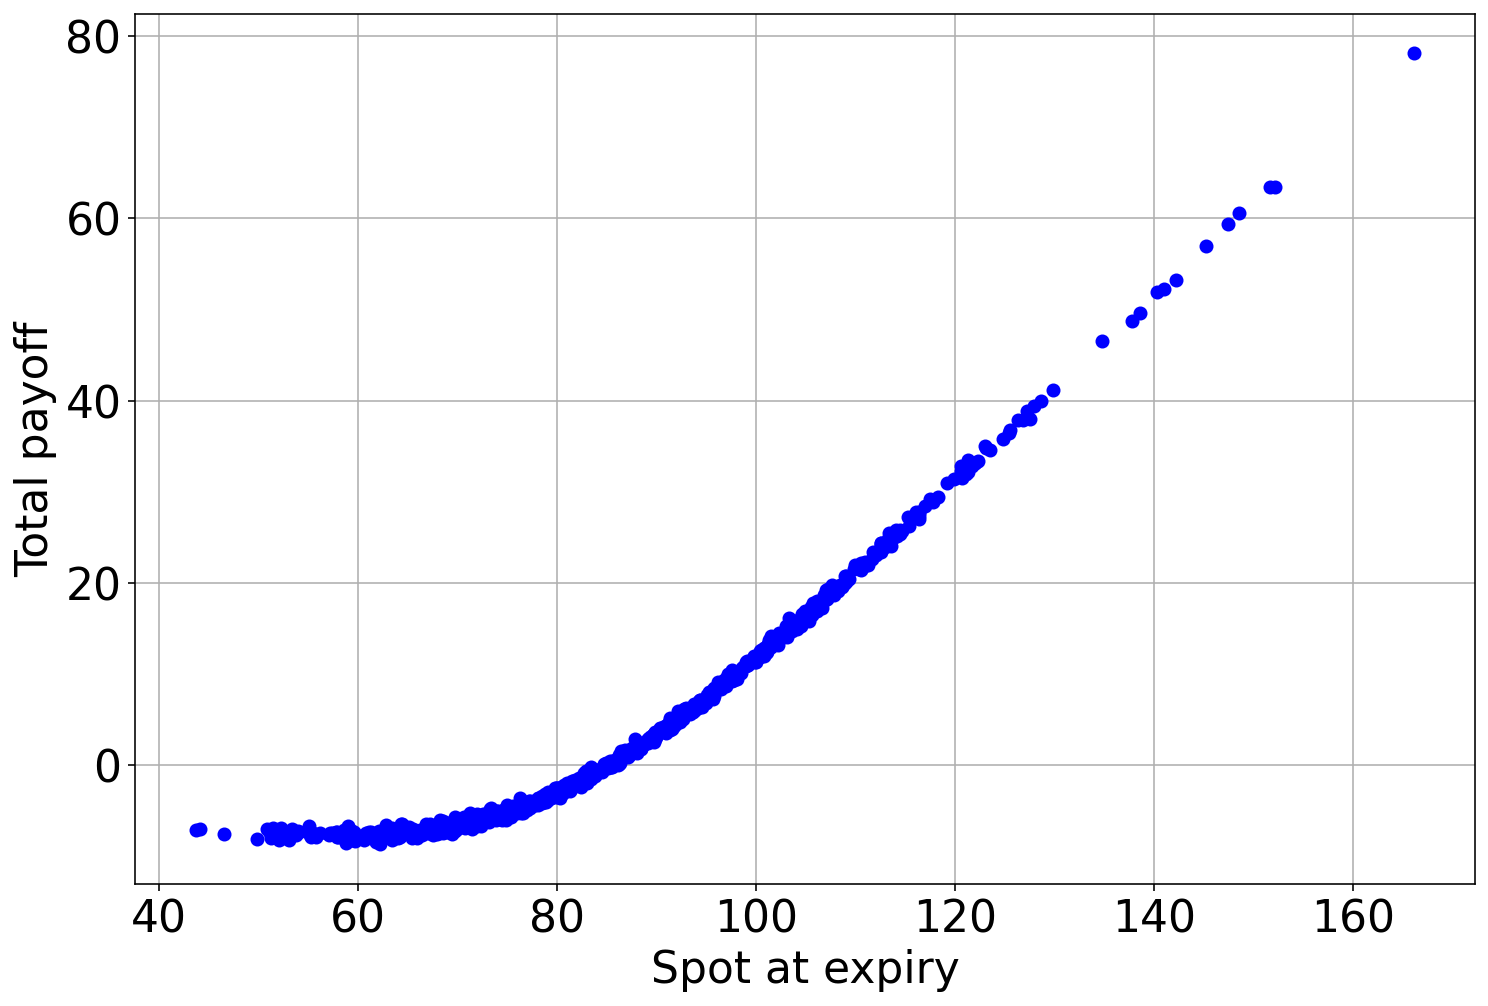

In [29]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

lw = 2.5 # line width
fs = 12  # fontsize
picWidth=12; picHeight=8;

matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(picWidth, picHeight))

plt.plot(S, P, 'bo', linewidth=lw)
plt.grid(True)
plt.xlabel('Spot at expiry')
plt.ylabel('Total payoff')
plt.show()

# Задача 4

Straddle это структура из опциона call и опционна put, у которых равны страйки.

Напишите код, который находит такой страйк для структуры straddle, при котором delta структуры равна нулю. (Delta neutral straddle).
Для численного нахождения корней функции можно использовать любой метод из стантартных библиотек, например
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html

Параметры для расчета:

In [3]:
from scipy import optimize

In [10]:
S0 = 80.; K = 85.; T = 1.0; r = 0.05; q = 0.01; sigma = 0.2
#просто возьмем функцию как сумму дельт и найдем ее корень
def strike(K):
    return bsm_delta(True, S0, K, T, r, q, sigma)+bsm_delta(False, S0, K, T, r, q, sigma)
print(optimize.brentq(strike,1,100))


84.94692372362877
